In [1]:
from dask.distributed import Client
from dask_kubernetes import KubeCluster

cluster = KubeCluster(n_workers=20)
client = Client(cluster)
cluster

import numpy as np
import xarray as xr
import pandas as pd
import hvplot.xarray
import matplotlib
import matplotlib.animation
from matplotlib import pyplot as plt
from rasterio import RasterioIOError
from tqdm.autonotebook import tqdm
%matplotlib inline
import skimage.morphology
#import richdem as rd
import scipy.ndimage

import cartopy.crs as ccrs
import affine
import pysheds
from pysheds.grid import Grid



distributed.scheduler - INFO - Clear task state
distributed.scheduler - INFO -   Scheduler at:   tcp://10.32.16.36:46625
distributed.scheduler - INFO -   dashboard at:                     :8787
distributed.scheduler - INFO - Receive client connection: Client-1d104674-9b9d-11ea-9812-7e5cda423d12
distributed.core - INFO - Starting established connection


/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:16: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  app.launch_new_instance()
distributed.scheduler - INFO - Register tcp://10.32.46.7:43013
distributed.scheduler - INFO - Starting worker compute stream, tcp://10.32.46.7:43013
distributed.core - INFO - Starting established connection
distributed.scheduler - INFO - Register tcp://10.32.43.4:39367
distributed.scheduler - INFO - Starting worker compute stream, tcp://10.32.43.4:39367
distributed.core - INFO - Starting established connection
distributed.scheduler - INFO - Register tcp://10.32.54.6:32965
distributed.scheduler - INFO - Starting worker compute stream, tcp://10.32.54.6:32965
distributed.core - INFO - Starting established connection
distributed.scheduler - INFO - Register tcp://10.32.36.4:39893
distributed.scheduler - INFO - Starting worker compute stream, 

In [2]:
def drainagebasins(ZintoDB):    
    grid = Grid() #Build empty Grid()
    Z = ZintoDB   
    grid.add_gridded_data(data=Z, data_name='dem', affine = affine.Affine(dset_r.transform[0],dset_r.transform[1],dset_r.transform[2],dset_r.transform[3],dset_r.transform[4],dset_r.transform[5]),
              crs=dset_r.crs)   #fill grid.dem with Z

    # Fill depressions in DEM
    grid.fill_depressions('dem', out_name='flooded_dem')

    # Specify directional mapping
    dirmap = (64, 128, 1, 2, 4, 8, 16, 32)

    # Compute flow directions
    grid.flowdir(data='dem', out_name='dir', dirmap=dirmap)
    
    # Calculate the seed points/pits for catchment calculation
    pits = skimage.morphology.extrema.local_maxima((grid.flooded_dem -grid.dem))
    labelled_pits = skimage.measure.label(pits>0,background=0)
    deepestpts =  np.argwhere(labelled_pits>0)
    
    #Iterate through the pits and calculate the catchment that surrounds each one
    labelled_catchment = np.zeros((grid.shape[0],grid.shape[1],len(deepestpts)))
    summed_catchment = np.zeros((grid.shape[0],grid.shape[1]))
    for i in np.arange(0,len(deepestpts)):
        y,x = deepestpts[i] #seed point
        grid.catchment(data='dir', x=x, y=y, dirmap=dirmap, out_name='catch',
           recursionlimit=15000, xytype='index') #use grid.catchment to calculate the pixels of the image that flow into the seedpoint
        
        #Remove holes from the catchment
        raw = skimage.morphology.remove_small_objects(grid.catch>0) 
        raw = skimage.morphology.remove_small_holes(raw)
        
        labelled_catchment[:,:,i] = np.int_(raw) #put the catchment in the array of catchments
        
        #Sum over the different catchments so that the unique drainage basins can be determined
        for labels in np.arange(0,len(deepestpts)):
            summed_catchment = summed_catchment + labelled_catchment[:,:,labels]
            
        
    pysheds_db = skimage.measure.label(summed_catchment,connectivity=2,background=100) #Label each unique catchment
    skimage_db = skimage.morphology.watershed(Z,markers=labelled_pits)
    I = np.argwhere(pysheds_db==1)
    for x,y in I:
        pysheds_db[x,y] = skimage_db[x,y]
    return pysheds_db,grid

In [3]:
def HypsometryOfAllBasins(ZintoHypsometry):
    Z = ZintoHypsometry
    cellArea = float(np.abs((dset_r.x[1]-dset_r.x[0])*(dset_r.y[1]-dset_r.y[0]))) #Area each cell overlaps
    
        
    # Fill depressions in DEM
    [pysheds_db,grid] = drainagebasins(Z) #Calculate drainage basins
    
    P_all = grid.flooded_dem-grid.dem; #P_all = water accomodation space
    
    if np.count_nonzero((P_all>0))<1: #If no water accomadation  space  exists, DEM is filled
        DEMfilled=1
        print('DEM is filled')
        return
    
    #Build  data structure  on each drainage basin
    num_basins = pysheds_db.max();
    b_dict = {'BasinNumber','BasinArea','MaskLogical','MaskI','MaskXY','skip','Volume','maxdepth','hw','h'}
    b = pd.DataFrame(data={},columns=b_dict)
    num_basins = np.max(pysheds_db)
    for kk in np.arange(0,num_basins):
        BasinNumber = kk;
        Mask = pysheds_db == kk; 
        BasinArea = (np.sum(np.int_(Mask.ravel()))*cellArea); # basin area in m^2
        MaskLogical = Mask;
        MaskXY = np.where(Mask);  # mask for the basin
        MaskI= np.ravel_multi_index(MaskXY,Z.shape)
        depths = P_all[MaskXY] #Water accomodation space in drainage basin
        if np.count_nonzero(depths>0)<1: #If accomodation space is zero, i.e, no nonzero depths
            skip = 1;
            h = 0;
            maxdepth = 0;
            Volume = 0;
            hw = np.zeros(depths.size)
            continue
        else:
            valid = np.argwhere(depths>=0)
            depths = depths[valid];
            heights = np.max(depths) - depths; #potential water height from bottom
            skip = 0;        
            Volume = (np.sum(depths.ravel())*cellArea);
            heights_sorted = np.sort(heights);
            while len(np.argwhere(np.diff(heights_sorted)==0))>0: #remove all identical pixels
                I = np.argwhere(np.diff(heights_sorted)==0);
                heights_sorted[I+1] = heights_sorted[I+1] +0.0001; # nudge the similar values up a tiny amount to avoid issues with the interpolation
            hw = heights_sorted;   # heights for hypsometry
            maxdepth = np.max(depths); # not actually the same as max(Heights) the smallest value of depths is not equal to zero
            h = 0;   # initial water depth is zero
        data={'BasinNumber':BasinNumber,
               'BasinArea':BasinArea,
               'MaskLogical':MaskLogical.ravel(),
               'MaskI':MaskI,
                'MaskXY': MaskXY,
               'skip':skip,
               'Volume':Volume,
               'maxdepth':maxdepth,
               'hw':hw,
               'h':h}
        DrainageBasin = pd.Series(data)
        b = b.append(DrainageBasin, ignore_index=True)
        
    return b, pysheds_db,  grid;

distributed.scheduler - INFO - Register tcp://10.32.71.3:41301
distributed.scheduler - INFO - Starting worker compute stream, tcp://10.32.71.3:41301
distributed.core - INFO - Starting established connection
distributed.scheduler - INFO - Register tcp://10.32.71.2:37191
distributed.scheduler - INFO - Starting worker compute stream, tcp://10.32.71.2:37191
distributed.core - INFO - Starting established connection


In [4]:
def AddWatertomg(Z_old,b):
    Zout = Z_old
    for tt in np.arange(0,len(b)):
        Addition = float(min(b.loc[tt].maxdepth,b.loc[tt].h));
        
        if  b.loc[tt].skip == 1:
            continue
        masked  = Zout[b.loc[tt].MaskXY]
        filledwaterheight = np.min(masked.ravel()) + Addition
    
        Zout[b.loc[tt].MaskXY] = np.maximum(Zout[b.loc[tt].MaskXY],filledwaterheight*np.ones((1,len(Zout[b.loc[tt].MaskXY]))))

    return Zout



distributed.scheduler - INFO - Register tcp://10.32.55.3:33089
distributed.scheduler - INFO - Starting worker compute stream, tcp://10.32.55.3:33089
distributed.core - INFO - Starting established connection
distributed.scheduler - INFO - Register tcp://10.32.55.2:37325
distributed.scheduler - INFO - Starting worker compute stream, tcp://10.32.55.2:37325
distributed.core - INFO - Starting established connection
distributed.scheduler - INFO - Register tcp://10.32.60.2:39337
distributed.scheduler - INFO - Starting worker compute stream, tcp://10.32.60.2:39337
distributed.core - INFO - Starting established connection
distributed.scheduler - INFO - Register tcp://10.32.60.3:44409
distributed.scheduler - INFO - Starting worker compute stream, tcp://10.32.60.3:44409
distributed.core - INFO - Starting established connection
distributed.scheduler - INFO - Register tcp://10.32.51.2:35553
distributed.scheduler - INFO - Starting worker compute stream, tcp://10.32.51.2:35553
distributed.core - INFO

In [44]:

dset = xr.open_rasterio('ClippedDEMforPartialFillingAnalysis.tif')
xn = np.linspace(dset.x[0],dset.x[-1],num=181)
yn = np.linspace(dset.y[0],dset.y[-1],num=90)

dset_r = dset.interp(x=xn, y=yn)

Z_original = np.squeeze(np.array(dset_r.data))#[2:-2,2:-2]
#Z_base= np.min(Z_original)*np.ones((Z_original.shape[0]+2,Z_original.shape[1]+2))
#Z_base[1:-1,1:-1]= Z_original
#Z_original = Z_base
Z = Z_original


grid = Grid()
grid.add_gridded_data(data=Z, data_name='dem', affine = affine.Affine(dset_r.transform[0],dset_r.transform[1],dset_r.transform[2],dset_r.transform[3],dset_r.transform[4],dset_r.transform[5]),
                      crs=dset_r.crs)
#grid.fill_pits('dem',out_name='filled_pits')

# Fill depressions in DEM
grid.fill_depressions('dem', out_name='flooded_dem')

# Specify directional mapping
dirmap = (64, 128, 1, 2, 4, 8, 16, 32)

# Compute flow directions
# -------------------------------------
grid.flowdir(data='dem', out_name='dir', dirmap=dirmap)

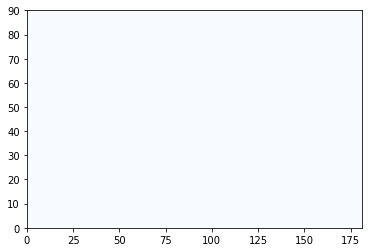

In [45]:
plotWhenReComputeBasins=1; # dicates if we plot the new catchment each time we compute one.

x = np.linspace(0,Z.shape[0],Z.shape[0])
y = np.linspace(0,Z.shape[1],Z.shape[1])
fig , ax = plt.subplots()
filler = np.zeros((Z.shape[0],Z.shape[1]))
w = ax.pcolormesh(filler, cmap='Blues')
#cax = ax.contour(filler,)
writer = matplotlib.animation.ImageMagickWriter(fps=15)

#set up time domain
DEMfilled = 0
cellArea = float(np.abs((dset_r.x[1]-dset_r.x[0])*(dset_r.y[1]-dset_r.y[0])))
sec_in_day = 24*60*60;
m = 1/365;    # melt rate m^3/day/m^2 or m/day
dt = 0.1;      # days
T = 500;     # days
t = np.arange(0,T,dt);  # days
#[pysheds_db, grid] = drainagebasins(Z)
b,  pysheds_db, grid = HypsometryOfAllBasins(Z)

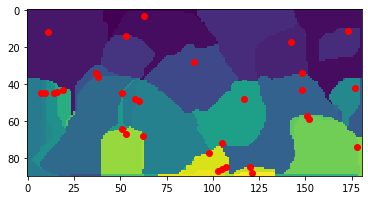

In [46]:
plt.imshow(pysheds_db)
#I = np.argmin(Z)
#x,y = np.unravel_index(I,Z.shape)
pits = skimage.morphology.extrema.local_maxima((grid.flooded_dem -grid.dem))
[x,y] = np.where(pits>0)
plt.scatter(y,x,c='r')

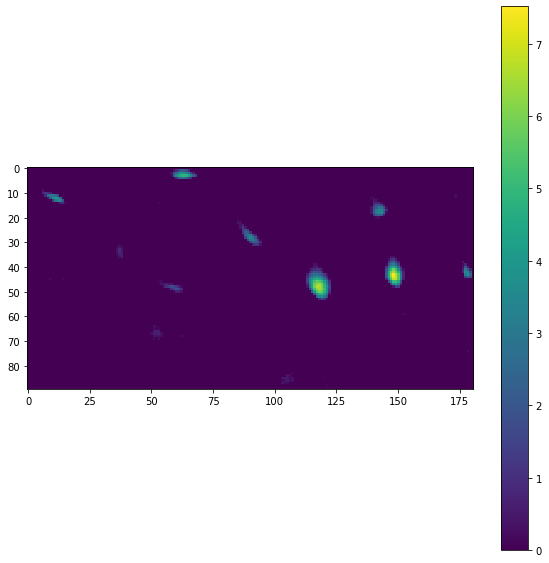

In [47]:
plt.figure(figsize=(10,10))
plt.imshow(grid.flooded_dem-grid.dem)
plt.colorbar()
#plt.scatter(y,x,marker=',', c='r')

In [48]:
for ii in np.arange(1,len(t)):  # for each time step
    for jj in np.arange(0,len(b)):   # for each basin
        if  b.loc[jj].skip == 1:  # skip this basin if there are no lakes in the catchment (should only be basins on the boundary.)
            continue
        
        # Lake surface area at this time step
        NearestI = np.argmin(abs(b.loc[jj].h - b.loc[jj].hw))+1; #index starts at 0, so 
        A = NearestI*cellArea; # this works because the interp1 version was: A = interp1(b(kk).hw, [1:length(b(kk).hw)]'*cellArea , b(jj).h(ii));

        # Change the lake depth based on this area and the input rate: m*b(jj).BasinArea
        b.at[jj, 'h'] = b.loc[jj].h + float(dt*m*b.loc[jj].BasinArea/A);

    
    
    # Catch if any basin is full
    if any(b.h>=b.maxdepth):
        Z_old = Z;         # record the topography before updating it
        Z_new = AddWatertomg(Z_old,b)  # Use this script to update the
        b,pysheds_db, grid = HypsometryOfAllBasins(Z_new);
        Z = Z_new
        if DEMfilled == 1:
            break
    if t[ii]%1 == 0:
        print([str(t[ii]), ' days'])

['1.0', ' days']
['2.0', ' days']
['3.0', ' days']
['4.0', ' days']
['5.0', ' days']
['6.0', ' days']
['7.0', ' days']
['8.0', ' days']
['9.0', ' days']
['10.0', ' days']
['11.0', ' days']
['12.0', ' days']
['13.0', ' days']
['14.0', ' days']
['15.0', ' days']
['16.0', ' days']
['17.0', ' days']
['18.0', ' days']
['19.0', ' days']
['20.0', ' days']
['21.0', ' days']
['22.0', ' days']
['23.0', ' days']
['24.0', ' days']
['25.0', ' days']
['26.0', ' days']
['27.0', ' days']
['28.0', ' days']
['29.0', ' days']
['30.0', ' days']
['31.0', ' days']
['32.0', ' days']
['33.0', ' days']
['34.0', ' days']
['35.0', ' days']
['36.0', ' days']
['37.0', ' days']
['38.0', ' days']
['39.0', ' days']
['40.0', ' days']
['41.0', ' days']
['42.0', ' days']
['43.0', ' days']
['44.0', ' days']
['45.0', ' days']
['46.0', ' days']
['47.0', ' days']
['48.0', ' days']
['49.0', ' days']
['50.0', ' days']
['51.0', ' days']
['52.0', ' days']
['53.0', ' days']
['54.0', ' days']
['55.0', ' days']
['56.0', ' days']
[

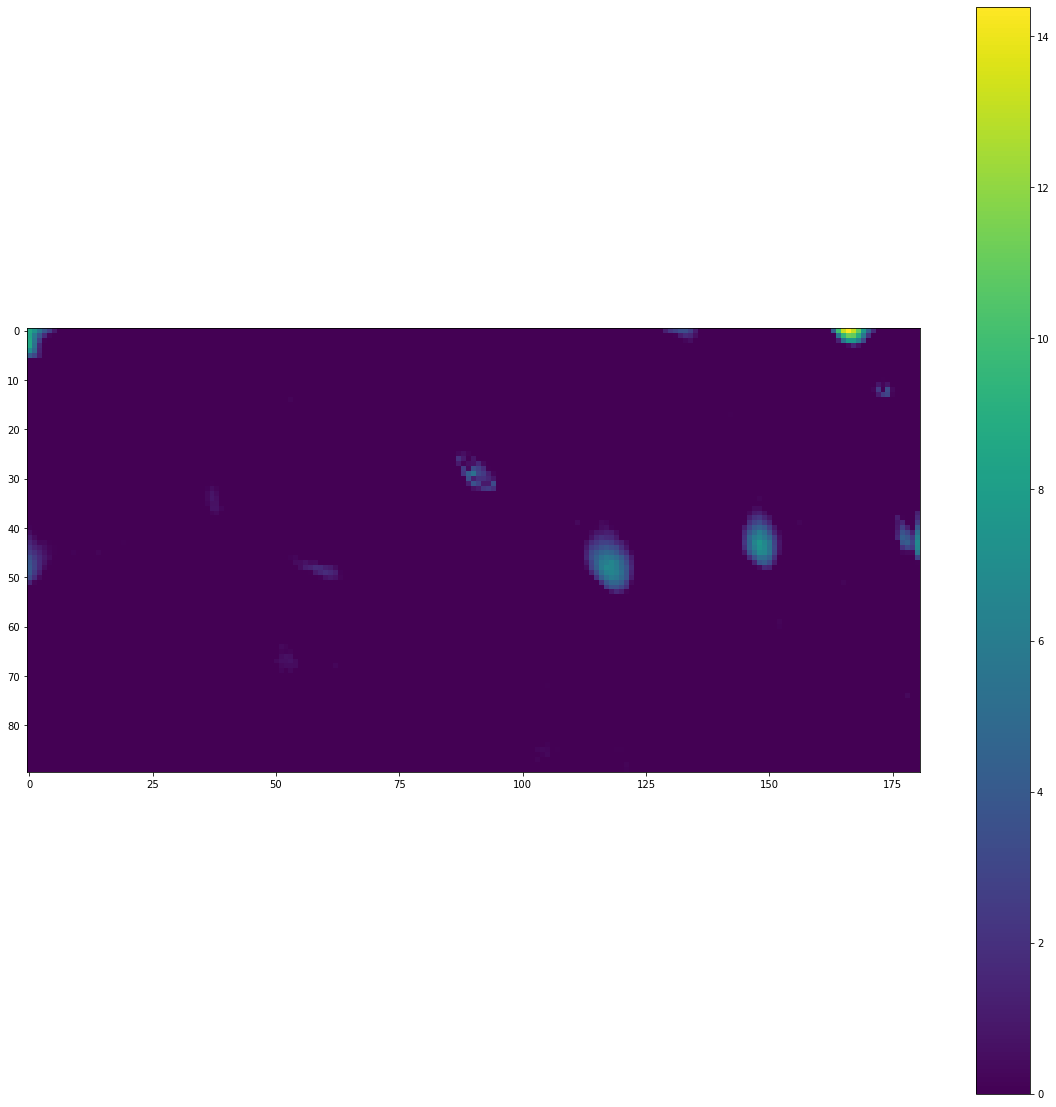

In [49]:
plt.figure(figsize=(20,20))
Z_original = np.squeeze(np.array(dset_r.data))
plt.imshow(Z-Z_original)
plt.colorbar()

In [65]:
b.h, b.maxdepth

(0     2.12044
 1     1.67007
 2    0.786189
 3    0.897258
 Name: h, dtype: object, 0     4.962491252389441
 1     4.036705643824575
 2    3.5349693027243347
 3    2.1976111573432036
 Name: maxdepth, dtype: object)

distributed.scheduler - INFO - Remove worker tcp://10.32.30.5:42497
distributed.core - INFO - Removing comms to tcp://10.32.30.5:42497


In [28]:
Z_150 = Z

In [20]:
Z_100 = Z;

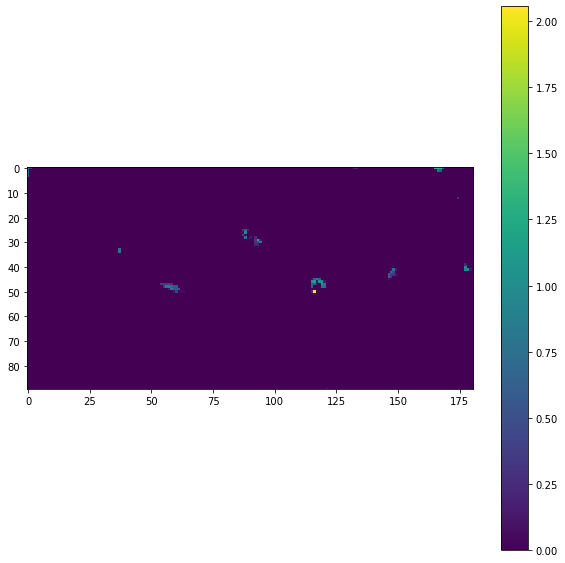

In [32]:
plt.figure(figsize=(10,10))
plt.imshow(Z_150-Z_100)
plt.colorbar()

In [170]:
Zout=Z
tt=2
Addition = float(min(b.loc[tt].maxdepth,b.loc[tt].h));
masked  = Zout[b.loc[tt].MaskXY]
filledwaterheight = np.min(masked.ravel()) + 3.62
filledwaterheight,  Addition

(654.1424940595916, 0.013524740614796069)

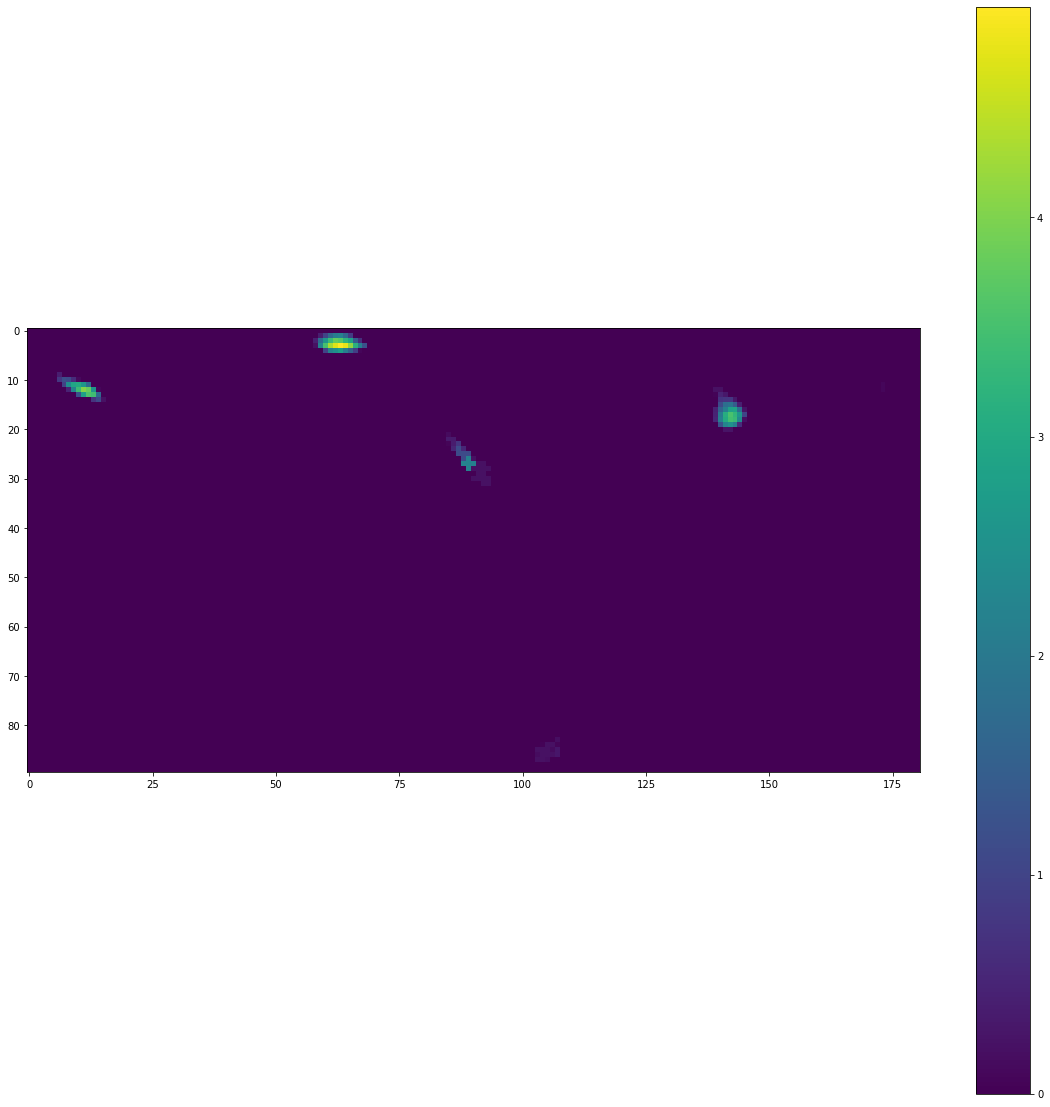

In [51]:
plt.figure(figsize=(20,20))
plt.imshow(grid.flooded_dem-grid.dem)
plt.colorbar()
#for x,y in deepestpts:
   # plt.scatter(y,x,marker='*')
#plt.scatter(pitsy[50],pitsx[50],c='r')

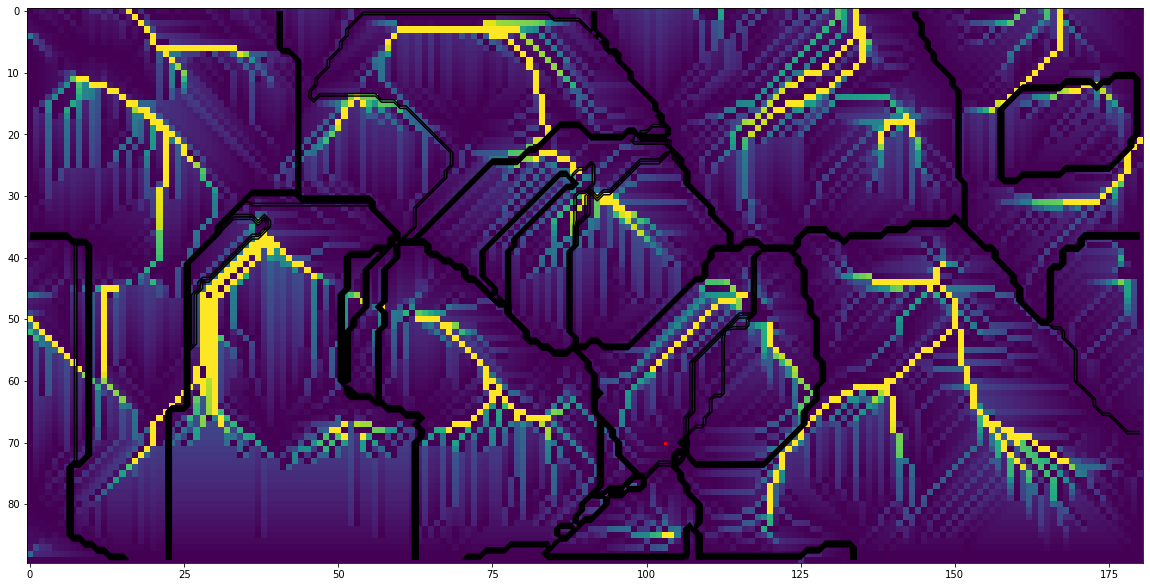

In [16]:
grid.accumulation('dir',dirmap=dirmap)
plt.figure(figsize=(20,20))
plt.scatter(103,70,c='r',s=10, marker='*')
plt.imshow(grid.acc, vmax=100)
plt.contour(pysheds_db,levels=50, colors='k')


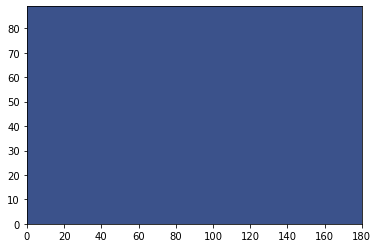

In [17]:
plt.contourf(Z - grid.dem)


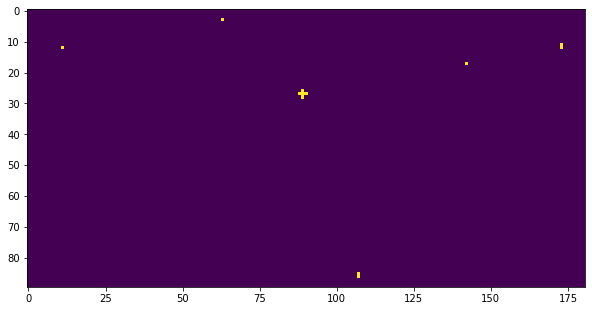

In [52]:
pits = skimage.morphology.extrema.local_maxima((grid.flooded_dem -grid.dem))
plt.figure(figsize=(10,10))
plt.imshow(pits)

12

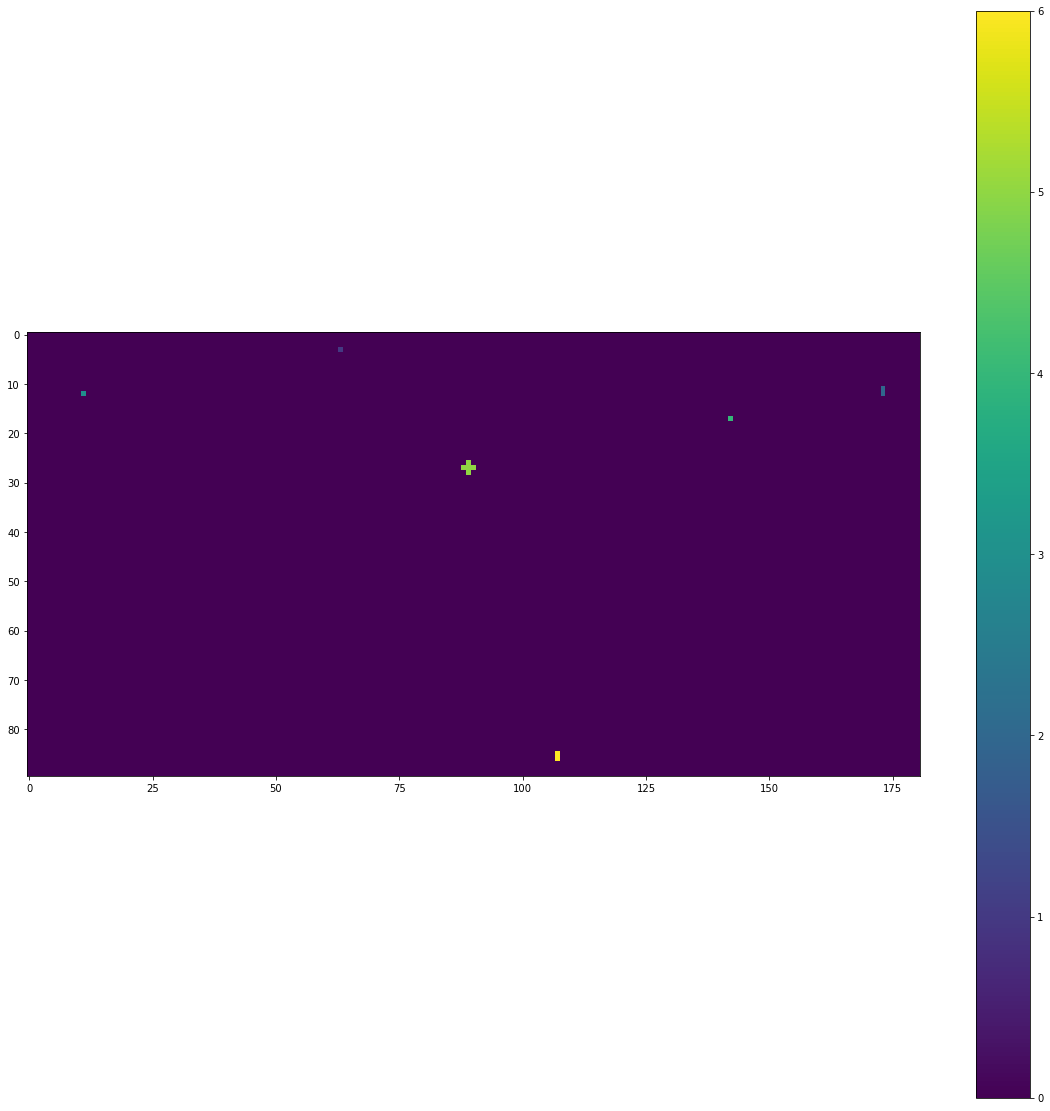

In [53]:
labelled_pits = skimage.measure.label(pits>0,background=0)
deepestpts =  np.argwhere(labelled_pits>0)
plt.figure(figsize=(20,20))
plt.imshow(labelled_pits)
plt.colorbar()
len(deepestpts)

distributed.scheduler - INFO - Register tcp://10.32.52.2:46115
distributed.scheduler - INFO - Starting worker compute stream, tcp://10.32.52.2:46115
distributed.core - INFO - Starting established connection
distributed.scheduler - INFO - Register tcp://10.32.52.3:44255
distributed.scheduler - INFO - Starting worker compute stream, tcp://10.32.52.3:44255
distributed.core - INFO - Starting established connection


In [67]:
labelled_catchment = np.zeros((grid.shape[0],grid.shape[1],len(deepestpts)))
summed_catchment = np.zeros((grid.shape[0],grid.shape[1]))
for i in np.arange(0,len(deepestpts)):
    y,x = deepestpts[i]
    grid.catchment(data='dir', x=x, y=y, dirmap=dirmap, out_name='catch',
       recursionlimit=15000, xytype='index')
    if len(np.nonzero(grid.catch))>(grid.catch.size-5) or len(np.nonzero(grid.catch))<2:
        continue
    else:
        #raw = skimage.morphology.remove_small_objects(np.abs(grid.catch)>0)
        raw = skimage.morphology.remove_small_holes(np.abs(grid.catch)>0)
        labelled_catchment[:,:,i] = raw
    for labels in np.arange(1,len(deepestpts)):
        summed_catchment = summed_catchment + labelled_catchment[:,:,labels]*labels
pysheds_db = skimage.measure.label(summed_catchment,connectivity=2,background=100)

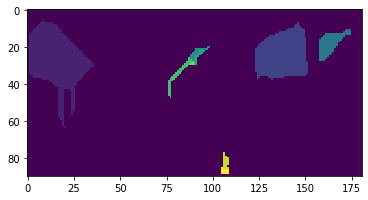

In [60]:
plt.imshow(pysheds_db)
#plt.colorbar()

In [61]:
skimage_db = skimage.morphology.watershed(Z,markers=labelled_pits)
I = np.argwhere(pysheds_db==1)
for x,y in I:
    pysheds_db[x,y] = skimage_db[x,y]


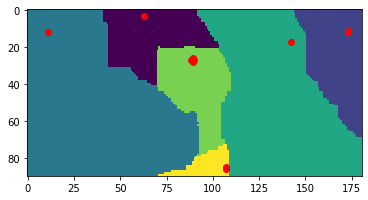

In [66]:
plt.imshow(skimage_db)
[x,y] = np.where(pits>0)
plt.scatter(y,x,c='r')

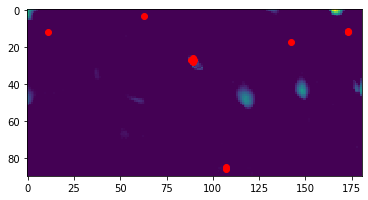

In [63]:
Z_original = np.squeeze(np.array(dset_r.data))
plt.imshow(Z-Z_original)
plt.scatter(y,x,c='r')

In [71]:
b_dict = {'BasinNumber','BasinArea','MaskLogical','MaskI','MaskXY','MaskLake','skip','Volume','maxdepth','hw','h'}
b = pd.DataFrame(data={},columns=b_dict)
num_basins = pysheds_db.max()
P_all = grid.flooded_dem-grid.dem
for kk in np.arange(0,num_basins):
        BasinNumber = kk;
        Mask = pysheds_db == kk;
        BasinArea = (np.sum(np.int_(Mask.ravel()))*cellArea); # basin area in m^2
        MaskLogical = Mask;
        MaskXY = np.where(Mask>0);  # mask for the basin
        MaskI= np.ravel_multi_index(MaskXY,Z.shape)
        depths = P_all[MaskXY];
        if np.count_nonzero(depths)<1:
            skip = 1;
            h = np.nan;
            maxdepth = np.nan;
            Volume = np.nan;
            hw = np.zeros(depths.size)
            continue
        else:
            skip = 0;
            valid = np.argwhere(depths>0)
            depths = depths[valid];
            Volume = (np.sum(depths.ravel())*cellArea).data;
            heights = depths.max() - depths;
            heights_sorted = np.sort(heights);
            while len(np.argwhere(np.diff(heights_sorted)==0))>0:
                I = np.argwhere(np.diff(heights_sorted)==0);
                heights_sorted[I+1] = heights_sorted[I+1] +0.0001; # nudge the similar values up a tiny amount to avoid issues with the interpolation
            hw = heights_sorted;   # heights for hypsometry
            maxdepth = depths.max(); # not actually the same as max(Heights) the smallest value of depths is not equal to zero
            h = 0;   # initial water depth is zero
        data={'BasinNumber':BasinNumber,
                                       'BasinArea':BasinArea,
                                       'MaskLogical':MaskLogical.ravel(),
                                       'MaskI':MaskI,
                                        'MaskXY': MaskXY,
                                       'skip':skip,
                                       'Volume':Volume,
                                       'maxdepth':maxdepth,
                                       'hw':hw,
                                       'h':h}
        DrainageBasin = pd.Series(data)
        b = b.append(DrainageBasin, ignore_index=True)

In [87]:
len(b.MaskXY[0][0])

12157

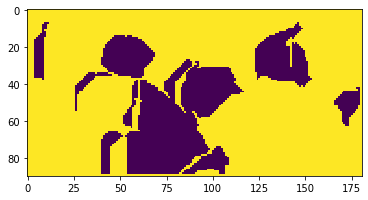

In [80]:
plt.imshow(pysheds_db==1)

In [69]:
kk=2
BasinNumber = kk;
Mask = pysheds_db == kk;
BasinArea = (np.sum(np.int_(Mask.ravel()))*cellArea); # basin area in m^2
MaskLogical = Mask;
MaskXY = np.where(Mask>0);  # mask for the basin
MaskI= np.ravel_multi_index(MaskXY,Z.shape)
depths = P_all[MaskXY];
if np.count_nonzero(depths)==0:
    skip = 1;
    h = np.nan;
    maxdepth = np.nan;
    Volume = np.nan;
    hw = np.zeros(depths.size)
else:
    skip = 0;
    valid = np.intersect1d(np.argwhere(~np.isnan(depths)>0),np.argwhere(depths>0))
    depths = depths[valid];
    Volume = (np.sum(depths.ravel())*cellArea).data;
    heights = depths.max() - depths;
    heights_sorted = np.sort(heights);
    while len(np.argwhere(np.diff(heights_sorted)==0))>0:
                I = np.argwhere(np.diff(heights_sorted)==0);
                heights_sorted[I+1] = heights_sorted[I+1] +0.0001; # nudge the similar values up a tiny amount to avoid issues with the interpolation
    hw = heights_sorted;   # heights for hypsometry
    maxdepth = depths.max(); # not actually the same as max(Heights) the smallest value of depths is not equal to zero
    h = 0;   # initial water depth is zero
data={'BasinNumber':BasinNumber,
        'BasinArea':BasinArea,
        'MaskLogical':MaskLogical.ravel(),
        'MaskI':MaskI,
        'MaskXY': MaskXY,
        'skip':skip,
        'Volume':Volume,
        'maxdepth':maxdepth,
       'hw':hw,
       'h':h}
DrainageBasin = pd.Series(data)

In [70]:
DrainageBasin

BasinNumber                                                    2
BasinArea                                            1.30527e+06
MaskLogical    [False, False, False, False, False, False, Fal...
MaskI          [1276, 1277, 1278, 1456, 1457, 1458, 1637, 163...
MaskXY         ([7, 7, 7, 8, 8, 8, 9, 9, 9, 10, 10, 10, 11, 1...
skip                                                           1
Volume                                                       NaN
maxdepth                                                     NaN
hw             [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
h                                                            NaN
dtype: object

In [51]:

Zout = Z
for tt in np.arange(0,len(b)):
    X,Y = b.loc[tt].MaskXY
    Addition = float(min(b.loc[tt].maxdepth,b.loc[tt].h));

    if  b.loc[tt].skip == 1:
        continue
    masked  = Z*np.reshape(b.loc[tt].MaskLogical,Z.shape)
    filledwaterheight = np.min(masked.ravel()) + Addition
    for ttt in np.arange(0, len(X)):
        Zout[X[ttt],Y[ttt]] = max(Z_old[X[ttt],Y[ttt]], filledwaterheight)